# Traditional Model Experiments AG News
This notebook implements and evaluates one traditional machine learning model Logistic Regression for text classification on the AG News dataset.

We compare three feature/embedding approaches:
1. TF-IDF (sparse bagv of words features)
2. Word2Vec CBOW (dense document vectors via averaged word embeddings)
3. Word2Vec Skip gram (dense document vectors via averaged word embeddings)

For fairness, all experiments use the same dataset splits and the same evaluation metrics.


In [ ]:
from google.colab import drive
drive.mount("/content/drive")


Mounted at /content/drive


## Load AG News dataset
The dataset is stored in Google Drive as `train.csv` and `test.csv`.
Each row contains:
- label (class index)
- title
- description

We load the files into pandas and inspect the shapes.

In [ ]:
import pandas as pd

data_path = "/content/drive/MyDrive/Text Classification/archive (2) (Unzipped Files)/"

train_df = pd.read_csv(data_path + "train.csv")
test_df = pd.read_csv(data_path + "test.csv")

print("Train columns:", train_df.columns.tolist())
print("Test columns:", test_df.columns.tolist())
print("Train shape:", train_df.shape)
print("Test shape:", test_df.shape)
train_df.head()


Train columns: ['Class Index', 'Title', 'Description']
Test columns: ['Class Index', 'Title', 'Description']
Train shape: (120000, 3)
Test shape: (7600, 3)


,Class Index,Title,Description
0,3,Wall St. Bears Claw Back Into the Black (Reuters),"Reuters - Short-sellers, Wall Street's dwindli..."
1,3,Carlyle Looks Toward Commercial Aerospace (Reu...,Reuters - Private investment firm Carlyle Grou...
2,3,Oil and Economy Cloud Stocks' Outlook (Reuters),Reuters - Soaring crude prices plus worries\ab...
3,3,Iraq Halts Oil Exports from Main Southern Pipe...,Reuters - Authorities have halted oil export\f...
4,3,"Oil prices soar to all-time record, posing new...","AFP - Tearaway world oil prices, toppling reco..."


## Standardize column names

If the dataset columns are:
- "Class Index", "Title", "Description" (common)
we rename them to:
- label, title, description




In [ ]:
# Case 1: Kaggle-style header columns
if len(train_df.columns) == 3 and ("Class Index" in train_df.columns or "Title" in train_df.columns or "Description" in train_df.columns):
    train_df = train_df.rename(columns={
        "Class Index": "label",
        "Title": "title",
        "Description": "description"
    })
    test_df = test_df.rename(columns={
        "Class Index": "label",
        "Title": "title",
        "Description": "description"
    })

# Case 2: Already standardized (label/title/description)
elif len(train_df.columns) == 3 and ("label" in train_df.columns and "title" in train_df.columns and "description" in train_df.columns):
    pass

# Case 3: No headers (rare for this Kaggle version) -> reload safely
else:
    train_df = pd.read_csv(
        data_path + "train.csv",
        header=None,
        names=["label", "title", "description"]
    )
    test_df = pd.read_csv(
        data_path + "test.csv",
        header=None,
        names=["label", "title", "description"]
    )

print("Standardized train columns:", train_df.columns.tolist())
print("Standardized test columns:", test_df.columns.tolist())

train_df.head()


Standardized train columns: ['label', 'title', 'description']
Standardized test columns: ['label', 'title', 'description']


,label,title,description
0,3,Wall St. Bears Claw Back Into the Black (Reuters),"Reuters - Short-sellers, Wall Street's dwindli..."
1,3,Carlyle Looks Toward Commercial Aerospace (Reu...,Reuters - Private investment firm Carlyle Grou...
2,3,Oil and Economy Cloud Stocks' Outlook (Reuters),Reuters - Soaring crude prices plus worries\ab...
3,3,Iraq Halts Oil Exports from Main Southern Pipe...,Reuters - Authorities have halted oil export\f...
4,3,"Oil prices soar to all-time record, posing new...","AFP - Tearaway world oil prices, toppling reco..."


## Create the combined text field

We combine `title` and `description` into a single input text column called `text`.
This ensures all models receive the same input representation.


In [ ]:
train_df["title"] = train_df["title"].astype(str)
train_df["description"] = train_df["description"].astype(str)
test_df["title"] = test_df["title"].astype(str)
test_df["description"] = test_df["description"].astype(str)

train_df["text"] = train_df["title"] + " " + train_df["description"]
test_df["text"] = test_df["title"] + " " + test_df["description"]

# Ensure labels are integers
train_df["label"] = train_df["label"].astype(int)
test_df["label"] = test_df["label"].astype(int)

print(train_df[["label", "text"]].head())
print("\nLabel distribution:\n", train_df["label"].value_counts().sort_index())


   label                                               text
0      3  Wall St. Bears Claw Back Into the Black (Reute...
1      3  Carlyle Looks Toward Commercial Aerospace (Reu...
2      3  Oil and Economy Cloud Stocks' Outlook (Reuters...
3      3  Iraq Halts Oil Exports from Main Southern Pipe...
4      3  Oil prices soar to all-time record, posing new...

Label distribution:
 label
1    30000
2    30000
3    30000
4    30000
Name: count, dtype: int64


## Exploratory Data Analysis

We visualize:
- Class distribution to confirm balance
- Text length distribution to understand document sizes
These help justify preprocessing and model choices in the report.


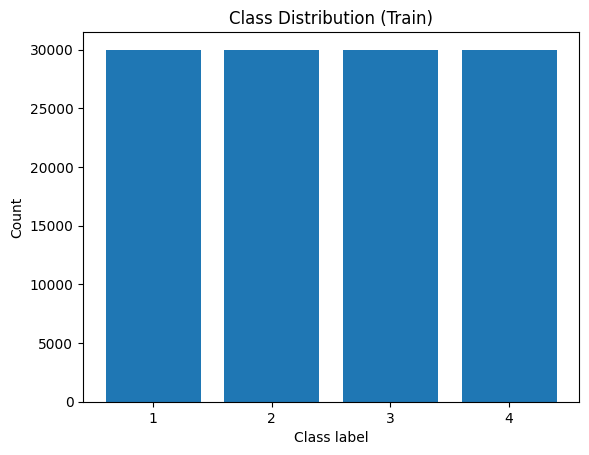

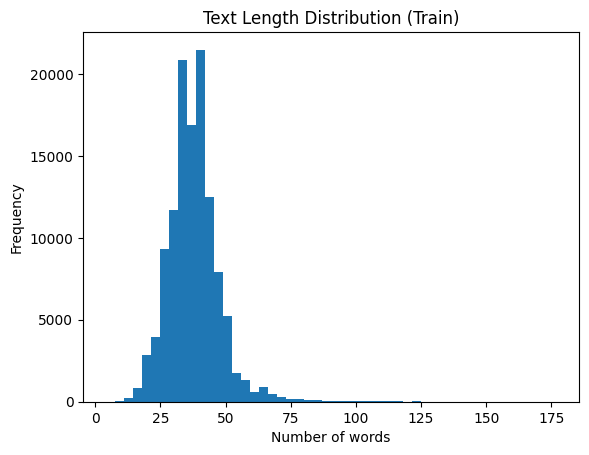

Average words: 37.84461666666667
Median words: 37.0


In [ ]:
import matplotlib.pyplot as plt

counts = train_df["label"].value_counts().sort_index()

plt.figure()
plt.bar(counts.index.astype(str), counts.values)
plt.title("Class Distribution (Train)")
plt.xlabel("Class label")
plt.ylabel("Count")
plt.show()

lengths = train_df["text"].str.split().apply(len)

plt.figure()
plt.hist(lengths, bins=50)
plt.title("Text Length Distribution (Train)")
plt.xlabel("Number of words")
plt.ylabel("Frequency")
plt.show()

print("Average words:", lengths.mean())
print("Median words:", lengths.median())


## Train/Validation split

We split the training data into train and validation subsets.
Stratification preserves the same class proportions in both splits.


In [ ]:
from sklearn.model_selection import train_test_split

X = train_df["text"]
y = train_df["label"]

X_train, X_val, y_train, y_val = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

print("Train split:", X_train.shape)
print("Validation split:", X_val.shape)


Train split: (96000,)
Validation split: (24000,)


## Evaluation metrics

We report:
- Accuracy
- Macro Precision
- Macro Recall
- Macro F1

Macro averages treat all classes equally, which is appropriate for multi-class classification.


In [ ]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

def evaluate(y_true, y_pred, label):
    acc = accuracy_score(y_true, y_pred)
    p, r, f1, _ = precision_recall_fscore_support(y_true, y_pred, average="macro")

    print(label)
    print("Accuracy:", round(acc, 4))
    print("Macro Precision:", round(p, 4))
    print("Macro Recall:", round(r, 4))
    print("Macro F1:", round(f1, 4))
    print()

    return acc, p, r, f1


 TF-IDF + Logistic Regression

TF-IDF represents text as weighted word and n-gram features.
Logistic Regression is a strong baseline for sparse text classification.

We tune a small grid of:
- n-gram range
- max features
- regularization strength (C)


In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

tfidf_model = Pipeline([
    ("tfidf", TfidfVectorizer(stop_words="english")),
    ("clf", LogisticRegression(max_iter=2000))
])

param_grid = {
    "tfidf__ngram_range": [(1, 1), (1, 2)],
    "tfidf__max_features": [30000, 60000],
    "clf__C": [0.1, 1, 10]
}

grid_tfidf = GridSearchCV(
    tfidf_model,
    param_grid,
    scoring="f1_macro",
    cv=3,
    n_jobs=-1
)

grid_tfidf.fit(X_train, y_train)

print("Best params:", grid_tfidf.best_params_)
print("Best CV macro F1:", round(grid_tfidf.best_score_, 4))

best_tfidf = grid_tfidf.best_estimator_
val_preds = best_tfidf.predict(X_val)
tfidf_val = evaluate(y_val, val_preds, "TF-IDF + Logistic Regression (Validation)")


Best params: {'clf__C': 1, 'tfidf__max_features': 30000, 'tfidf__ngram_range': (1, 2)}
Best CV macro F1: 0.9165
TF-IDF + Logistic Regression (Validation)
Accuracy: 0.9218
Macro Precision: 0.9216
Macro Recall: 0.9218
Macro F1: 0.9216



## TF-IDF evaluation on the official test set

After selecting the best model on validation, we evaluate on the official test set.


In [ ]:
X_test = test_df["text"]
y_test = test_df["label"]

test_preds = best_tfidf.predict(X_test)
tfidf_test = evaluate(y_test, test_preds, "TF-IDF + Logistic Regression (Test)")


TF-IDF + Logistic Regression (Test)
Accuracy: 0.9186
Macro Precision: 0.9183
Macro Recall: 0.9186
Macro F1: 0.9184



## Word2Vec setup

Word2Vec requires tokenized text.
We tokenize text into lowercase alphabetic tokens.

For traditional models, we convert each document into a fixed-length vector
by averaging the vectors of all words found in the Word2Vec vocabulary.


In [ ]:
!pip -q install gensim

import re

def tokenize(text):
    text = text.lower()
    return re.findall(r"[a-z]+", text)

train_tokens = X_train.apply(tokenize).tolist()
val_tokens = X_val.apply(tokenize).tolist()
test_tokens = X_test.apply(tokenize).tolist()

print("Example tokens:", train_tokens[0][:20])


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.9/27.9 MB 62.1 MB/s eta 0:00:00
Example tokens: ['clijsters', 'unsure', 'about', 'latest', 'injury', 'says', 'hewitt', 'tokyo', 'reuters', 'belgian', 'kim', 'clijsters', 'is', 'unsure', 'about', 'the', 'exact', 'nature', 'of', 'the']


## Convert token lists to document vectors

We represent each document by averaging its word vectors.
If a document contains no known tokens, we use a zero vector.


In [ ]:
import numpy as np

def doc_vector(tokens, model, size):
    vectors = []
    for w in tokens:
        if w in model.wv:
            vectors.append(model.wv[w])
    if len(vectors) == 0:
        return np.zeros(size)
    return np.mean(vectors, axis=0)

def make_matrix(token_lists, model, size):
    return np.vstack([doc_vector(toks, model, size) for toks in token_lists])


##  Word2Vec CBOW + Logistic Regression

CBOW predicts a target word using surrounding context words.
We train CBOW embeddings on the training split only, then train Logistic Regression
on averaged document vectors.


In [ ]:
from gensim.models import Word2Vec
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

vector_size = 200

w2v_cbow = Word2Vec(
    sentences=train_tokens,
    vector_size=vector_size,
    window=5,
    min_count=2,
    workers=4,
    sg=0
)

X_train_cbow = make_matrix(train_tokens, w2v_cbow, vector_size)
X_val_cbow = make_matrix(val_tokens, w2v_cbow, vector_size)
X_test_cbow = make_matrix(test_tokens, w2v_cbow, vector_size)

cbow_pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("clf", LogisticRegression(max_iter=2000))
])

cbow_grid = {"clf__C": [0.1, 1, 10]}

grid_cbow = GridSearchCV(
    cbow_pipe,
    cbow_grid,
    scoring="f1_macro",
    cv=3,
    n_jobs=-1
)

grid_cbow.fit(X_train_cbow, y_train)

print("Best params:", grid_cbow.best_params_)
print("Best CV macro F1:", round(grid_cbow.best_score_, 4))

best_cbow = grid_cbow.best_estimator_

val_preds_cbow = best_cbow.predict(X_val_cbow)
cbow_val = evaluate(y_val, val_preds_cbow, "Word2Vec CBOW + Logistic Regression (Validation)")

test_preds_cbow = best_cbow.predict(X_test_cbow)
cbow_test = evaluate(y_test, test_preds_cbow, "Word2Vec CBOW + Logistic Regression (Test)")


Best params: {'clf__C': 1}
Best CV macro F1: 0.8854
Word2Vec CBOW + Logistic Regression (Validation)
Accuracy: 0.8881
Macro Precision: 0.8878
Macro Recall: 0.8881
Macro F1: 0.8879

Word2Vec CBOW + Logistic Regression (Test)
Accuracy: 0.8833
Macro Precision: 0.883
Macro Recall: 0.8833
Macro F1: 0.8831



##  Word2Vec Skip-gram + Logistic Regression

Skip-gram predicts surrounding words from a center word and often captures
useful semantic relationships.

We repeat the same pipeline as CBOW but train Word2Vec with Skip-gram.


In [ ]:
w2v_skip = Word2Vec(
    sentences=train_tokens,
    vector_size=vector_size,
    window=5,
    min_count=2,
    workers=4,
    sg=1
)

X_train_skip = make_matrix(train_tokens, w2v_skip, vector_size)
X_val_skip = make_matrix(val_tokens, w2v_skip, vector_size)
X_test_skip = make_matrix(test_tokens, w2v_skip, vector_size)

skip_pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("clf", LogisticRegression(max_iter=2000))
])

skip_grid = {"clf__C": [0.1, 1, 10]}

grid_skip = GridSearchCV(
    skip_pipe,
    skip_grid,
    scoring="f1_macro",
    cv=3,
    n_jobs=-1
)

grid_skip.fit(X_train_skip, y_train)

print("Best params:", grid_skip.best_params_)
print("Best CV macro F1:", round(grid_skip.best_score_, 4))

best_skip = grid_skip.best_estimator_

val_preds_skip = best_skip.predict(X_val_skip)
skip_val = evaluate(y_val, val_preds_skip, "Word2Vec Skip-gram + Logistic Regression (Validation)")

test_preds_skip = best_skip.predict(X_test_skip)
skip_test = evaluate(y_test, test_preds_skip, "Word2Vec Skip-gram + Logistic Regression (Test)")


Best params: {'clf__C': 0.1}
Best CV macro F1: 0.8968
Word2Vec Skip-gram + Logistic Regression (Validation)
Accuracy: 0.9014
Macro Precision: 0.9012
Macro Recall: 0.9014
Macro F1: 0.9012

Word2Vec Skip-gram + Logistic Regression (Test)
Accuracy: 0.8945
Macro Precision: 0.8942
Macro Recall: 0.8945
Macro F1: 0.8943



## Comparison table

We summarize final test performance across the three embedding approaches.
This table can be exported and copied into the group report.


In [ ]:
results = [
    ["Logistic Regression", "TF-IDF", tfidf_test[0], tfidf_test[1], tfidf_test[2], tfidf_test[3]],
    ["Logistic Regression", "Word2Vec CBOW", cbow_test[0], cbow_test[1], cbow_test[2], cbow_test[3]],
    ["Logistic Regression", "Word2Vec Skip-gram", skip_test[0], skip_test[1], skip_test[2], skip_test[3]],
]

results_df = pd.DataFrame(
    results,
    columns=["Model", "Embedding", "Accuracy", "Macro Precision", "Macro Recall", "Macro F1"]
)

results_df


,Model,Embedding,Accuracy,Macro Precision,Macro Recall,Macro F1
0,Logistic Regression,TF-IDF,0.918553,0.918288,0.918553,0.918360
1,Logistic Regression,Word2Vec CBOW,0.883289,0.882982,0.883289,0.883087
2,Logistic Regression,Word2Vec Skip-gram,0.894474,0.894231,0.894474,0.894313


## Save results for the report and GitHub

We save the final results table to Google Drive


In [ ]:
save_path = "/content/drive/MyDrive/Text Classification/traditional_model_results.csv"
results_df.to_csv(save_path, index=False)
print("Saved:", save_path)


Saved: /content/drive/MyDrive/Text Classification/traditional_model_results.csv


## Discussion

This study evaluated the performance of a traditional machine learning model, Logistic Regression, across three different text representation techniques: TF-IDF, Word2Vec CBOW, and Word2Vec Skip gram, using the AG News multiclass classification dataset.

The results show that TF-IDF combined with Logistic Regression achieved the strongest overall performance across accuracy and macro F1-score. This outcome aligns with existing literature, which suggests that linear classifiers often perform exceptionally well with sparse, high-dimensional representations such as TF-IDF. TF-IDF captures discriminative keywords and n-gram patterns that are highly informative for topic classification tasks like news categorization.

In contrast, Word2Vec based approaches (both CBOW and Skip-gram) produced lower performance when paired with Logistic Regression. Although Word2Vec embeddings capture semantic similarity at the word level, averaging word vectors to form document representations can lead to information loss, particularly for longer documents. Important syntactic cues, word order, and class-specific keywords may be diluted during the averaging process. As a result, dense embeddings are not always optimal for traditional linear models without additional architectural complexity.

Between the two Word2Vec variants, Skip gram showed slightly better performance than CBOW. This is consistent with prior findings that Skip-gram tends to capture more informative representations for less frequent or context specific words, which are common in news articles. However, the performance gap between the two Word2Vec variants remained relatively small compared to the difference between TF-IDF and dense embeddings.

Overall, these findings highlight that traditional models paired with carefully engineered sparse features can remain competitive, even when compared to more modern embedding techniques. This also underscores the importance of matching embedding strategies to model architectures rather than assuming that dense embeddings will universally outperform classical representations.
